In [1]:
%pwd
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import scikitplot as skplt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.externals import joblib
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from umap.umap_ import UMAP
import hdbscan
import pickle
import matplotlib.colors as mcolors
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

#Random Number
r = 42
labels = [-1, 'CN', 'EMCI', 'LMCI', 'AD']
labels_ad = [-1, 'CONTROL', 'AD']
n_clusters = 4

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#Loading in data
df = pd.read_csv('Data/ADNI_Gene_Expression_Profile.csv', header=2)
df = df[6:]
df = df.drop(df.columns[[1, -1]], axis=1)
df = df.rename({'SubjectID':'ProbeSet', 'Unnamed: 2':'Gene'}, axis=1)
df = df.set_index(['Gene', 'ProbeSet'])
df = df.loc[df.index.dropna()]

dfanno = pd.read_csv('Data/ADNIMERGE.csv')
dfanno = pd.Series(dfanno['DX_bl'].values, index=dfanno['PTID'])
dfanno = dfanno.groupby(dfanno.index).last()
dfanno = dfanno.loc[df.columns]

C:\Users\andre\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (329,480) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\andre\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19,20,103,104) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Load Genes
with open("genes.txt", "rb") as fp:   # Unpickling
    genes = pickle.load(fp)

In [4]:
#Choose Genes
dfanno = dfanno.loc[df.columns]
dftop = df.loc[genes]
dftop = dftop.groupby(dftop.index).first()
dftop = dftop.astype(float)

In [5]:
#Standardize
dftop = dftop.astype(float)
dftop = dftop.sub(dftop.mean(1), axis=0).div(dftop.std(1), axis=0)
X = dftop.T
y = dfanno

In [6]:
#Oversampling
X, y = SMOTETomek(random_state=r, n_jobs=-1).fit_resample(X, y)

In [7]:
y_ad = np.where(y=='CN', 'CONTROL', y)
y_ad = np.where(y_ad=='LMCI', 'CONTROL', y_ad)
y_ad = np.where(y_ad=='EMCI', 'CONTROL', y_ad)

In [8]:
def fixedWidthClusterMap(df, cmap='RdBu', s=30, top=0.05, side=20, num=20, bar=0, up=0, t=0.02, z_score=True):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = plt.rcParams['figure.dpi']
    mw = plt.rcParams['figure.subplot.right']-plt.rcParams['figure.subplot.left']
    mh = plt.rcParams['figure.subplot.top']-plt.rcParams['figure.subplot.bottom']
    Ny,Nx = df.shape
    w = (Nx*s/dpi)/0.8/mw
    h = (Ny*s/dpi)/0.8/mh
    axWidth = (Nx*s)/(w*dpi)
    axHeight = (Ny*s)/(h*dpi)
    
    # do the actual plot
    if z_score:
        grid = sns.clustermap(df, figsize=(w, h), metric="euclidean", center=0, cmap=cmap, cbar_kws={"orientation": "horizontal"}, z_score=0)
    else:
        grid = sns.clustermap(df, figsize=(w, h), metric="euclidean", center=0, cmap=cmap, cbar_kws={"orientation": "horizontal"})


    # resize dendrograms to match

    row = grid.ax_row_dendrogram.get_position()
    grid.ax_row_dendrogram.set_position([row.x0-row.width*(side-1), row.y0, 
                                         row.width*side, axHeight])
    col = grid.ax_col_dendrogram.get_position()
    grid.ax_col_dendrogram.set_position([col.x0, col.y0+col.height*0.01-col.height*up,
                                         axWidth, col.height*top])

    # resize heatmap
    hm = grid.ax_heatmap.get_position()
    grid.ax_heatmap.set_position([hm.x0, hm.y0, 
                                  axWidth, axHeight])

    cbar = grid.cax.get_position()
    grid.cax.set_position([cbar.x0, cbar.y0+col.height*top-col.height*bar-col.height*up, .8, t/(num/20)])

    return grid # return ClusterGrid object

In [9]:
def geheatmapclustgene(X, c, title='', top=1, side=1, num=20, bar=0, s=30, up=0, t=0.02):
    #Gene Expression
    
    ge = pd.DataFrame()
    c = c[c!=-1]
    for i in range(0, c.nunique()):
        ge[i] = X.T[c[c==i].index].mean(axis=1)

    #Sort
    ge['Standard Deviation'] = ge.std(axis=1) #Standard Deviation
    ge = ge.sort_values(by=['Standard Deviation'], ascending=False)
    ge = ge.drop(['Standard Deviation'], axis=1) 

    #Heatmap
    if num=='all':
        cm = fixedWidthClusterMap(ge.T.corr(), top=top, side=side, s=s, num=ge.T.shape[1], bar=bar, up=up, t=t, z_score=False)
    else:
        cm = fixedWidthClusterMap(ge[:num].T.corr(), top=top, side=side, s=s, num=num, bar=bar, up=up, t=t, z_score=False)

In [10]:
def geheatmapclustgeneall(X, title='', top=1, side=1, num=20, bar=0, s=20, up=0, t=0.02):    
    #Sort
    X=X.T
    X['Standard Deviation'] = X.std(axis=1) #Standard Deviation
    X = X.sort_values(by=['Standard Deviation'], ascending=False)
    X = X.drop(['Standard Deviation'], axis=1) 

    #Heatmap
    if num=='all':
        cm = fixedWidthClusterMap(X.T.corr(), top=top, side=side, s=s, num=X.T.shape[1], bar=bar, up=up, t=t, z_score=False)
    else:
        cm = fixedWidthClusterMap(X[:num].T.corr(), top=top, side=side, s=s, num=num, bar=bar, up=up, t=t, z_score=False)

In [11]:
#Heatmap Gene Expression
def geheatmapclust(X, c, title='', top=0.05, side=20, num=20, s=30, bar=0, up=0, t=0.02):
    #Gene Expression
    
    ge = pd.DataFrame()
    c = c[c!=-1]
    for i in range(0, c.nunique()):
        ge[i] = X.T[c[c==i].index].mean(axis=1)

    #Sort
    ge['Standard Deviation'] = ge.std(axis=1) #Standard Deviation
    ge = ge.sort_values(by=['Standard Deviation'], ascending=False)
    ge = ge.drop(['Standard Deviation'], axis=1) 
    
    #Heatmap
    if num=='all':
        cm = fixedWidthClusterMap(ge, top=top, side=side, num=ge.shape[1], bar=bar, s=s, up=up, t=t)
    else:
        cm = fixedWidthClusterMap(ge[:num], top=top, side=side, num=num, bar=bar, s=s, up=up, t=t)

In [12]:
#Heatmap Gene Expression
def geheatmap(X, c, title='', num=20):
    #Gene Expression
    
    ge = pd.DataFrame()
    c = c[c!=-1]
    for i in range(0, c.nunique()):
        ge[i] = X.T[c[c==i].index].mean(axis=1)

    #Sort
    ge['Standard Deviation'] = ge.std(axis=1) #Standard Deviation
    ge = ge.sort_values(by=['Standard Deviation'], ascending=False)
    ge = ge.drop(['Standard Deviation'], axis=1) 

    #Heatmap
    fig = plt.figure(figsize = (2*c.nunique(), 10))
    plt.title(title, fontsize = 20)
    if num=='all':
        sns.heatmap(ge, cmap='RdBu', square=True)
    else:
        sns.heatmap(ge[:num], cmap='RdBu', square=True)

In [1]:
def scatterplot(data, c, labels=[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], title='', d=False, tsne=False, umap=False, ge=False):
    colors = ['grey', 'r', 'b', 'g', 'y', 'purple', 'c', 'm', 'brown', 'pink', 'lime', 'orange', 'navy', 'turquoise']

    if labels != [-1, 'CN', 'EMCI', 'LMCI', 'AD'] and not ge and labels != [-1, 'CONTROL', 'AD'] :
        labels = range(-1, c.max()+1)
    if ge:
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(1,1,1)
    else:
        fig = plt.figure(figsize = (8, 8))
        ax = fig.add_subplot(1,1,1) 
    s = 1
    a = 1
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if tsne:
        principalDf = pd.DataFrame(data = X_embedded, columns = ['tSNE 1', 'tSNE 2'])
        finalDf = pd.concat((principalDf, pd.Series(c)), axis=1)

        ax.set_xlabel('tSNE 1', fontsize = 15)
        ax.set_ylabel('tSNE 2', fontsize = 15)
        ax.set_title(title+'tSNE', fontsize = 20)
        finalDf.columns = ['tSNE 1', 'tSNE 2', 'majorCluster']
   
        for label, color in zip(labels, colors):
            indicesToKeep = finalDf['majorCluster'] == label
            ax.scatter(finalDf.loc[indicesToKeep, 'tSNE 1'],
                       finalDf.loc[indicesToKeep, 'tSNE 2'],
                       c = color,
                       s = s, alpha=a, label=label, marker='s')
        plt.legend()

    elif umap:
        principalDf = pd.DataFrame(data = X_embedded, columns = ['UMAP 1', 'UMAP 2'])
        finalDf = pd.concat((principalDf, pd.Series(c)), axis=1)

        ax.set_xlabel('UMAP 1', fontsize = 15)
        ax.set_ylabel('UMAP 2', fontsize = 15)
        ax.set_title(title+'UMAP', fontsize = 20)
        finalDf.columns = ['UMAP 1', 'UMAP 2', 'majorCluster']
   
        for label, color in zip(labels, colors):
            indicesToKeep = finalDf['majorCluster'] == label
            ax.scatter(finalDf.loc[indicesToKeep, 'UMAP 1'],
                       finalDf.loc[indicesToKeep, 'UMAP 2'],
                       c = color,
                       s = s, alpha=a, label=label, marker='s')
        plt.legend()

    elif ge: 
        principalDf = pd.DataFrame(data = data, columns = ['UMAP 1', 'UMAP 2'])
        finalDf = pd.concat((principalDf, pd.Series(((c-c.min())/(c.max()-c.min())))), axis=1)

        ax.set_xlabel('UMAP 1', fontsize = 15)
        ax.set_ylabel('UMAP 2', fontsize = 15)
        ax.set_title(title+'UMAP', fontsize = 20)

        sc = ax.scatter(finalDf['UMAP 1'], finalDf['UMAP 2'], c=((c-c.min())/(c.max()-c.min())), s=s, alpha=a, marker='s', cmap=mcolors.LinearSegmentedColormap.from_list("", ['whitesmoke', 'r']))
        cbar = plt.colorbar(sc)
        cbar.set_alpha(1)
        cbar.draw_all()
        cbar.outline.set_visible(False)
        cbar.solids.set_rasterized(True)
        cbar.solids.set_edgecolor("face")

    elif not d:
        principalDf = pd.DataFrame(data = data, columns = ['principal component 1', 'principal component 2'])
        finalDf = pd.concat((principalDf, pd.Series(c)), axis=1)

        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        ax.set_title('PCA', fontsize = 20)
        finalDf.columns = ['principal component 1', 'principal component 2', 'majorCluster']

        for label, color in zip(labels, colors):
            indicesToKeep = finalDf['majorCluster'] == label
            ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                       finalDf.loc[indicesToKeep, 'principal component 2'],
                       c = color,
                       s = s, alpha=a, label=label, marker='s')
        plt.legend()

    elif d:
        principalDf = pd.DataFrame(data = data, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
        finalDf = pd.concat((principalDf, pd.Series(c)), axis=1)

        ax = Axes3D(fig)
        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        ax.set_zlabel('Principal Component 3', fontsize = 15)

        ax.set_title('PCA', fontsize = 20)
        finalDf.columns = ['principal component 1', 'principal component 2', 'principal component 3', 'majorCluster']

        for label, color in zip(labels, colors):
            indicesToKeep = finalDf['majorCluster'] == label
            ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                       finalDf.loc[indicesToKeep, 'principal component 2'],
                       finalDf.loc[indicesToKeep, 'principal component 3'],
                       c = color,
                       s = s, alpha=a, label=label, marker='s')    
        plt.legend()
        

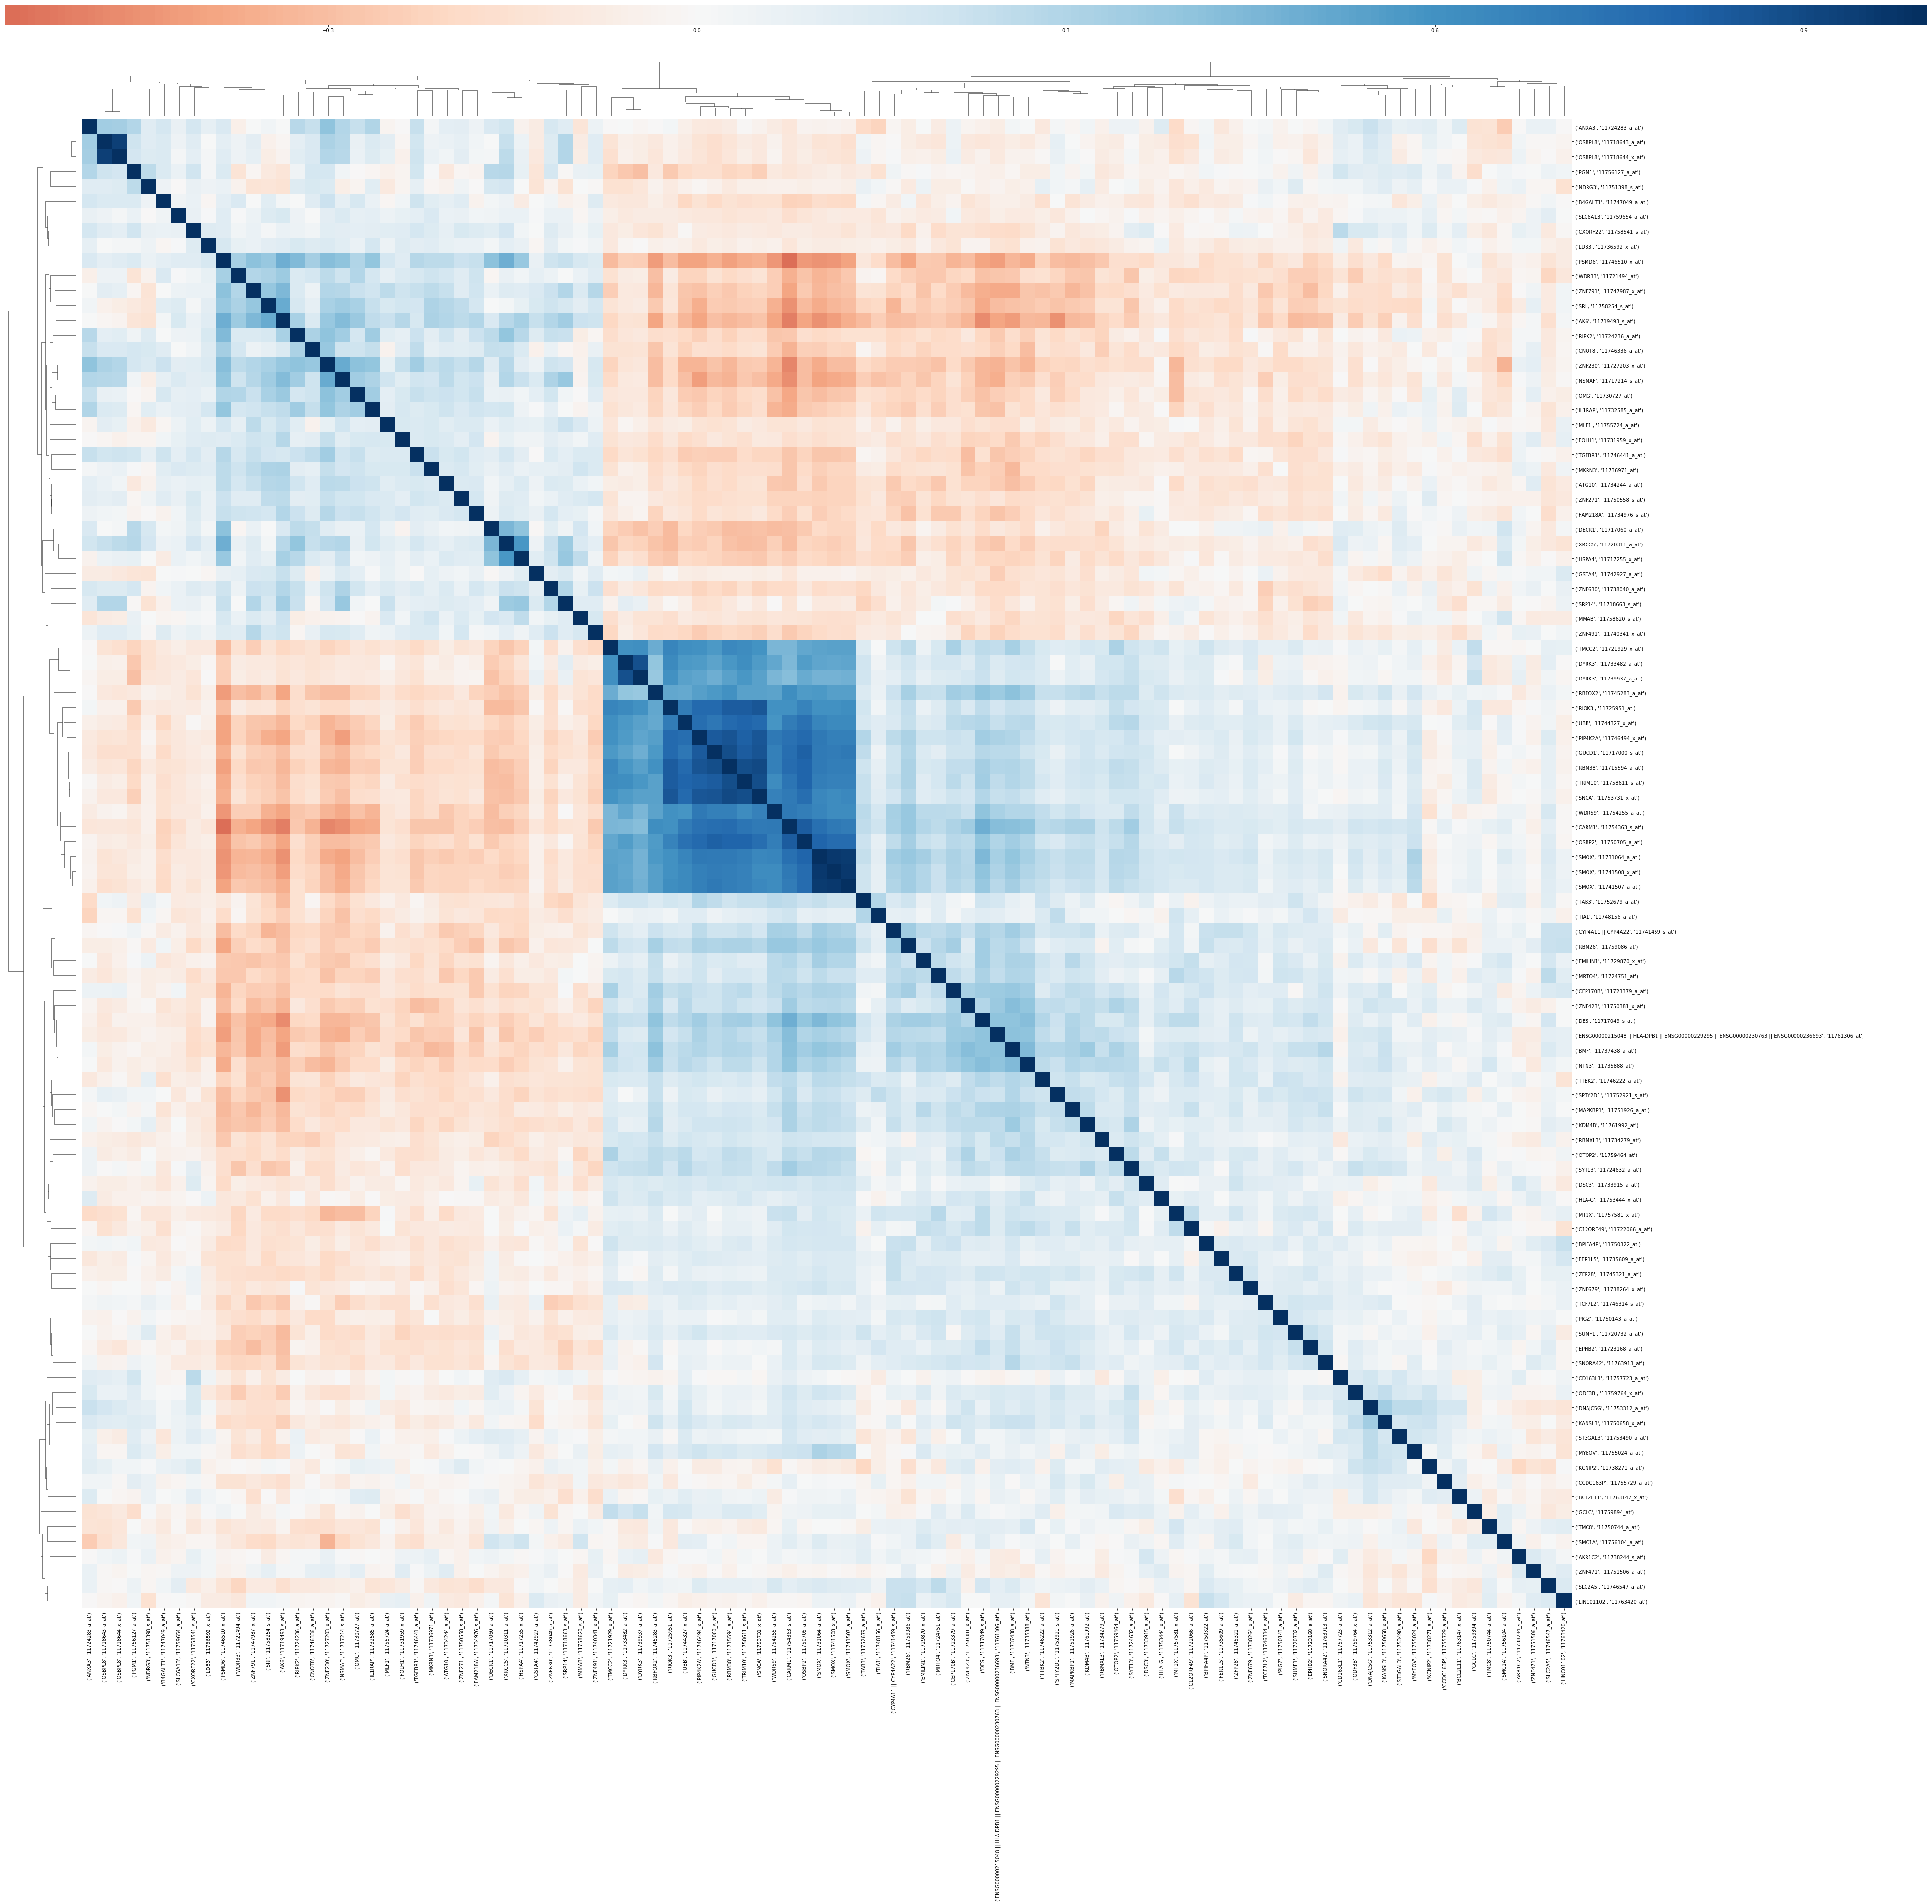

In [14]:
geheatmapclustgeneall(X, title='Pearson Correlation', top=1, side=1, num='all', s=30, up=4.1, t=0.04)

In [15]:
#K means clustering
clust = KMeans(
    n_clusters=n_clusters, init='random',
    n_init=10, max_iter=2000, 
    tol=1e-04, random_state=0
)

y_km = clust.fit_predict(X)
km = pd.Series(y_km)

In [16]:
pd.crosstab(y, y_km, margins=True) 

col_0,0,1,2,3,All
row_0,,,,,
AD,2,138,17,103,260
CN,40,32,90,94,256
EMCI,56,24,68,112,260
LMCI,38,32,87,99,256
All,136,226,262,408,1032


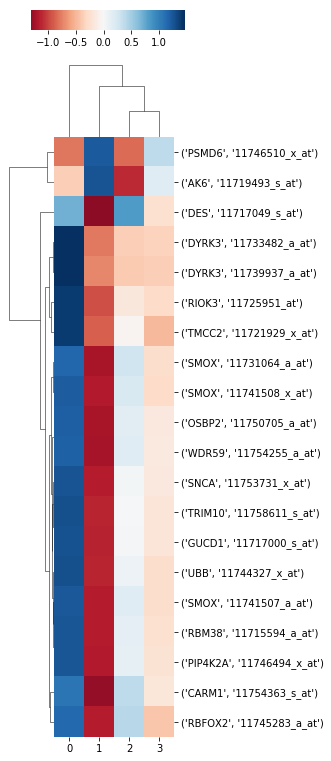

In [17]:
geheatmapclust(X, km, title='K means Clustering of genes', side=2, top=0.5)

In [18]:
#Hierarchy Clustering
clust = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

y_h = clust.fit_predict(X)
pd.crosstab(y, y_h, margins=True) 
h = pd.Series(y_h)

In [19]:
pd.crosstab(y, y_h, margins=True) 

col_0,0,1,2,3,All
row_0,,,,,
AD,111,16,133,0,260
CN,133,82,24,17,256
EMCI,139,87,18,16,260
LMCI,137,77,27,15,256
All,520,262,202,48,1032


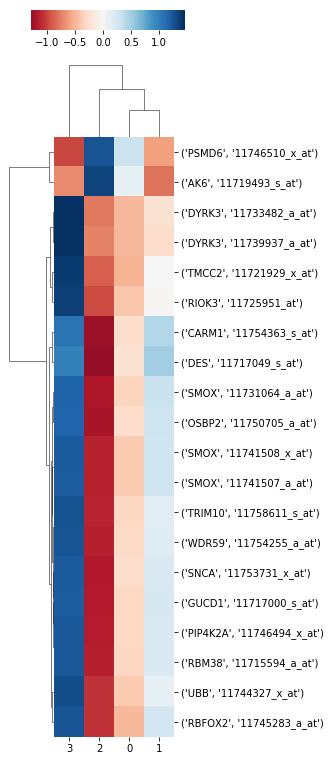

In [20]:
geheatmapclust(X, h, title='Hierarchial Clustering of genes', side=2, top=0.5)

In [21]:
#PCA
pca = PCA()
dfpc = pca.fit_transform(X)

[0.186887   0.05868579 0.04082993 0.02998513 0.02888003 0.02743094
 0.02291123 0.02021001 0.01939837 0.01776649 0.01574032 0.01436923
 0.01384    0.01282288 0.01235935 0.0120769  0.01175522 0.01171804
 0.01137818 0.01114007 0.010869   0.01080642 0.01027842 0.01011964
 0.00990788 0.00964121 0.00944198 0.00938784 0.00915591 0.00888221
 0.00870462 0.00856865 0.00843443 0.00822912 0.00820783 0.00809773
 0.00779628 0.00776033 0.00762867 0.00752267 0.00747591 0.00738978
 0.00701008 0.00692488 0.00687555 0.00673329 0.00662784 0.006459
 0.00635424 0.0062718  0.00621548 0.00602434 0.00599549 0.00575526
 0.00562128 0.00558521 0.00555382 0.00543354 0.00524116 0.00518988
 0.00504329 0.00495358 0.00486568 0.00472542 0.00462796 0.00458598
 0.00442112 0.00436952 0.00423869 0.0041131  0.00407479 0.00399504
 0.00388521 0.00388233 0.00377079 0.00363998 0.0035823  0.00340196
 0.00326569 0.00309591 0.00292799 0.00283776 0.00279513 0.00273012
 0.00265961 0.0024881  0.00244453 0.00232946 0.00216729 0.001867

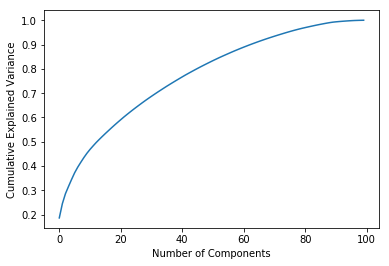

In [22]:
#Scree Plot
print(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

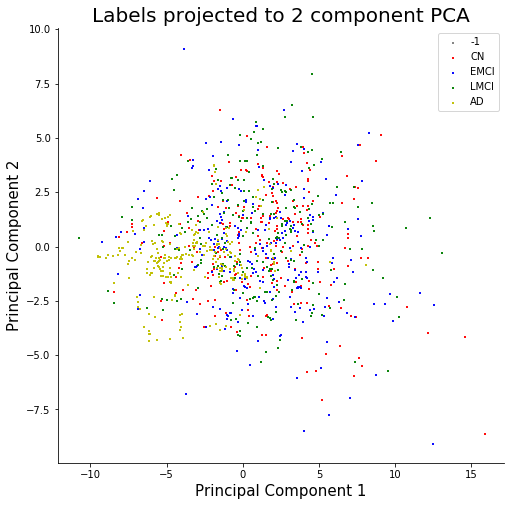

In [23]:
scatterplot(dfpc[:,:2], y, labels=labels, title='')
plt.savefig('pca.png', format='svg', dpi=1200)

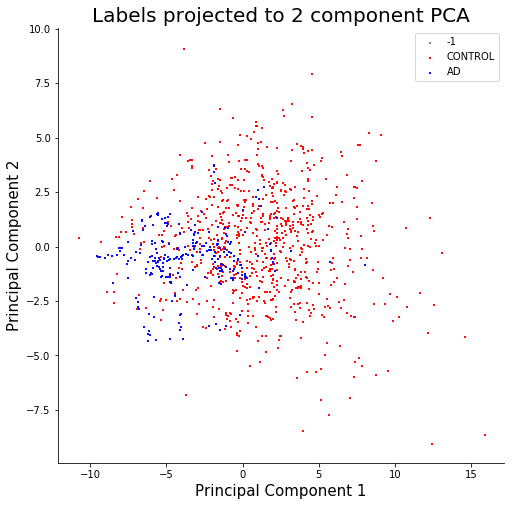

In [24]:
scatterplot(dfpc[:,:2], y_ad, labels=labels_ad, title='')
plt.savefig('pca2.png', format='svg', dpi=1200)

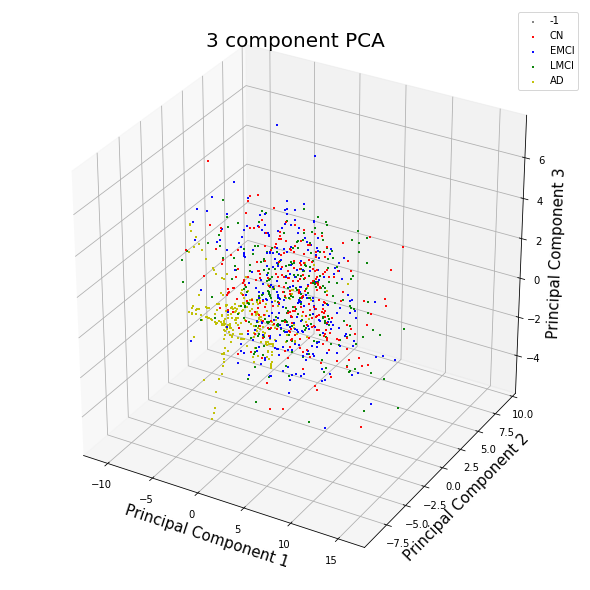

In [25]:
scatterplot(dfpc[:,:3], y, labels=labels, title='Labels projected to', d=True)
plt.savefig('pca3d.png')

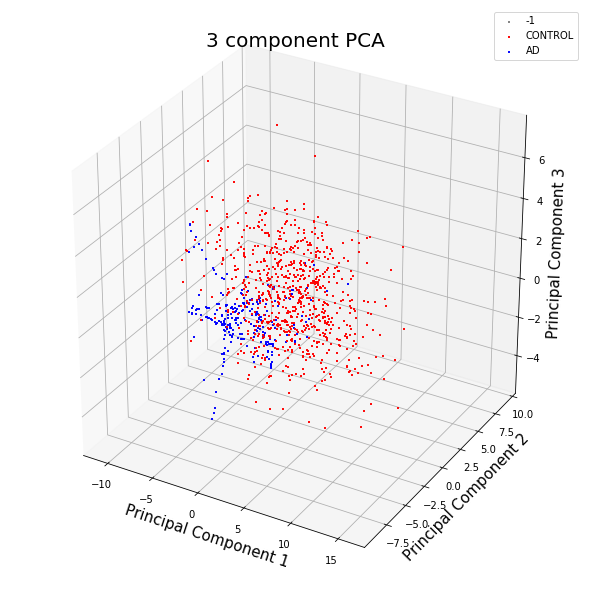

In [26]:
scatterplot(dfpc[:,:3], y_ad, labels=labels_ad, title='Labels projected to', d=True)
plt.savefig('pca3d2.png')

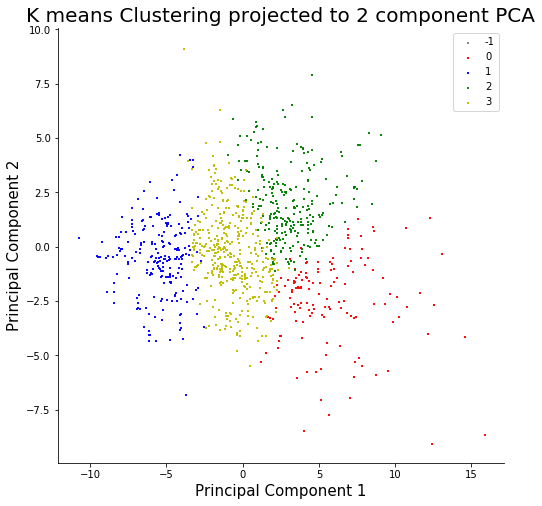

In [27]:
scatterplot(dfpc[:,:2], km, title='K means Clustering projected to')
plt.savefig('kmeanpca.png')

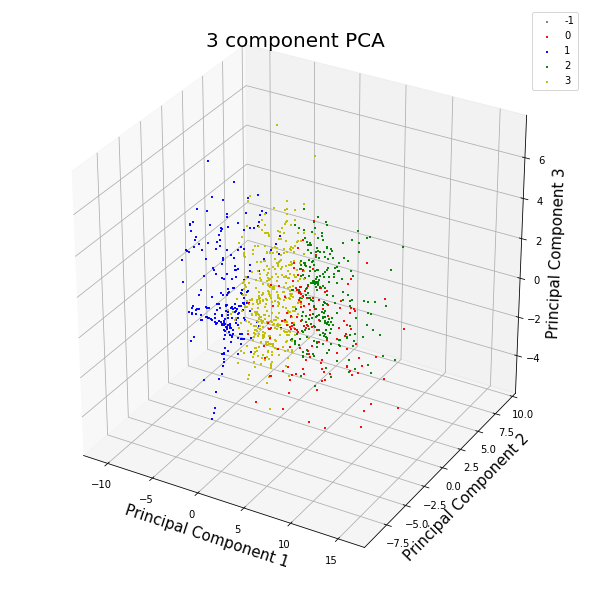

In [28]:
scatterplot(dfpc[:,:3], km, title='K means Clustering projected to', d=True)

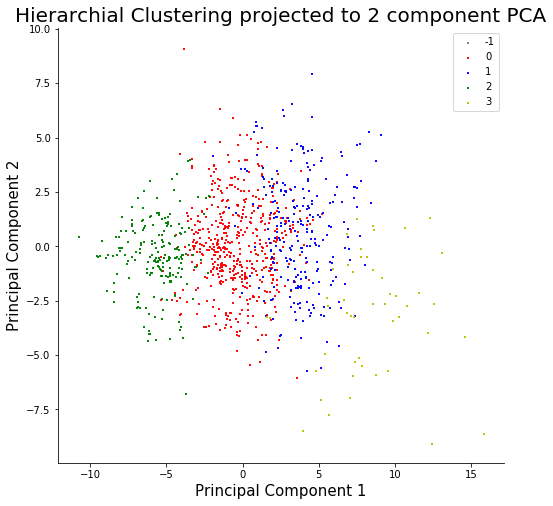

In [29]:
scatterplot(dfpc[:,:2], h, title='Hierarchial Clustering projected to')

In [30]:
X_embedded = TSNE(n_components=2, perplexity=30, verbose=10, n_iter=5000).fit_transform(dfpc[:,:20])

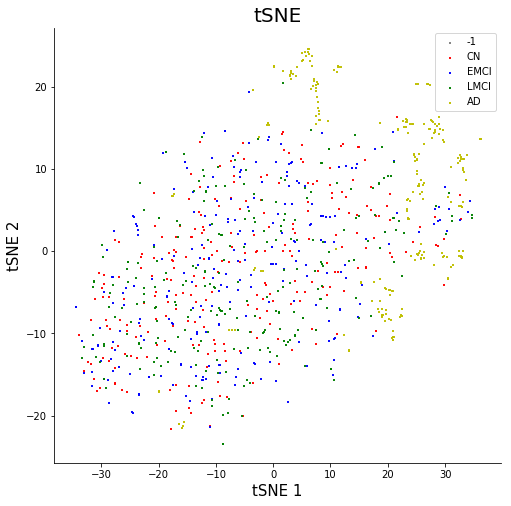

In [31]:
scatterplot(X_embedded, y, labels=labels, tsne=True)
plt.savefig('tsne.png', format='svg', dpi=1200)

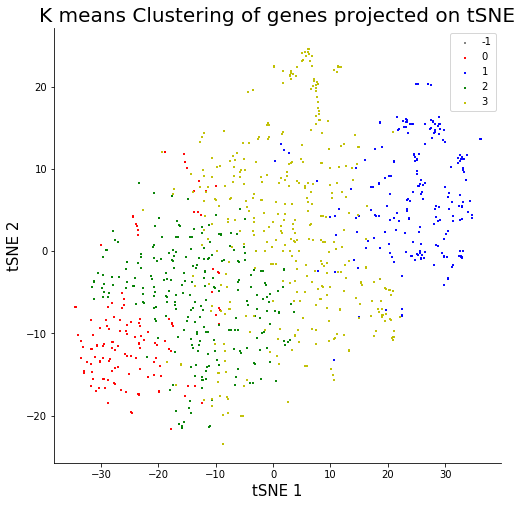

In [32]:
scatterplot(X_embedded, km, tsne=True, title='K means Clustering of genes projected on ')
plt.savefig('kmeanstsne.png')

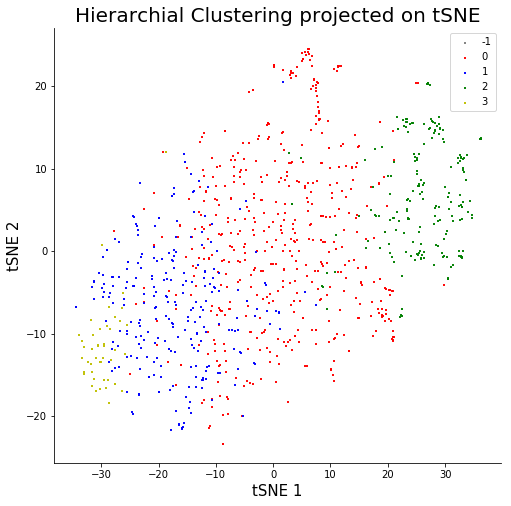

In [33]:
scatterplot(X_embedded, h, tsne=True, title='Hierarchial Clustering projected on ')
plt.savefig('htsne.png')

In [34]:
#HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=21, min_samples=10)

y_hdb = hdb.fit_predict(X_embedded)
hdb = pd.Series(y_hdb)

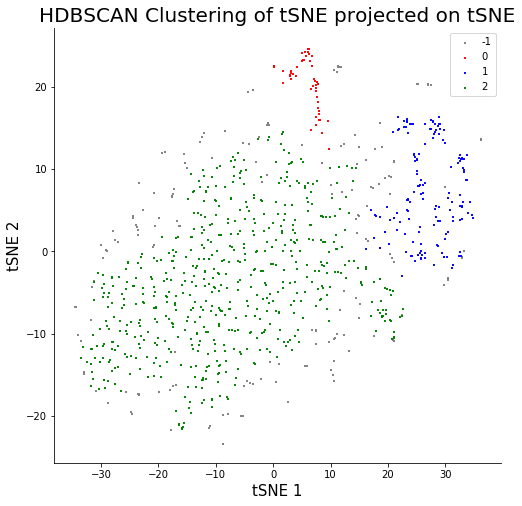

In [35]:
scatterplot(X_embedded, hdb, tsne=True, title='HDBSCAN Clustering of ')
plt.savefig('hdbscantsne', format='svg', dpi=1200)

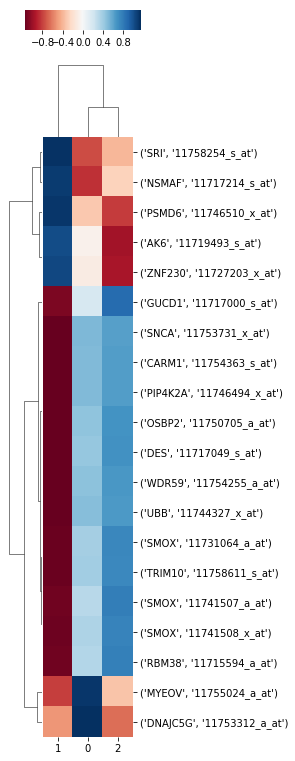

In [36]:
geheatmapclust(X, hdb, title='HDBSCAN Clustering of tSNE', side=2, top=0.5)
plt.savefig('gehdbscantsne', bbox_inches = "tight", format='svg', dpi=1200)

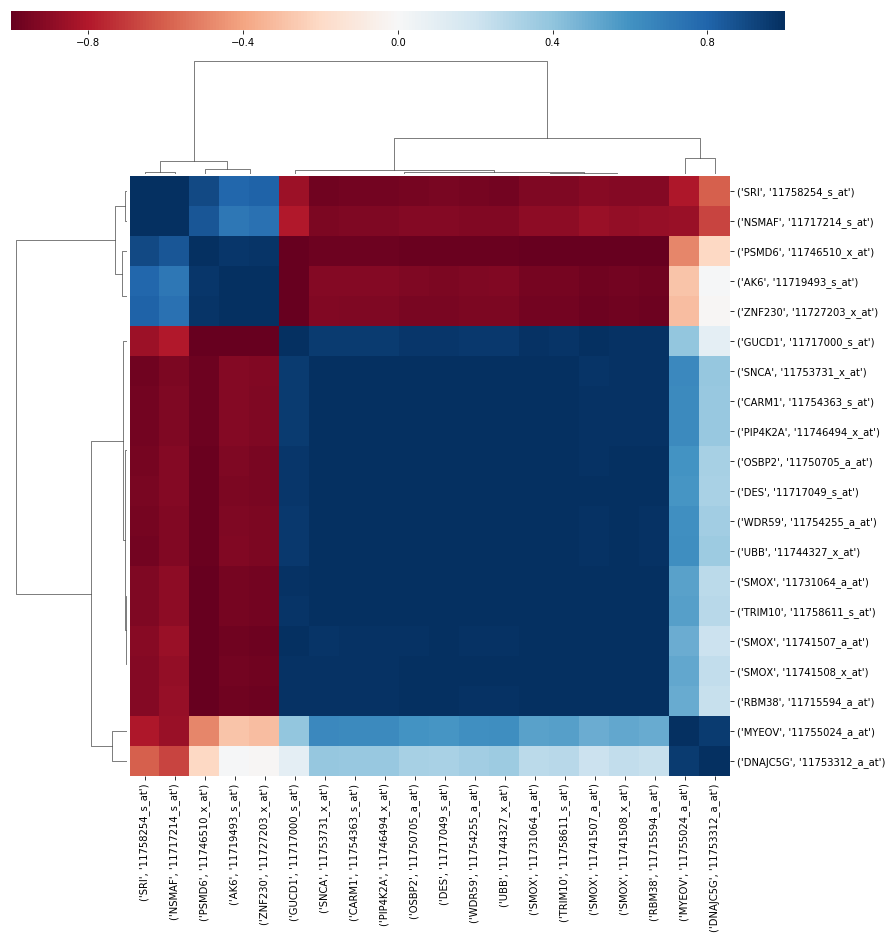

In [37]:
geheatmapclustgene(X, hdb, title='HDBSCAN Clustering of tSNE', top=1, side=1, up=0.25)

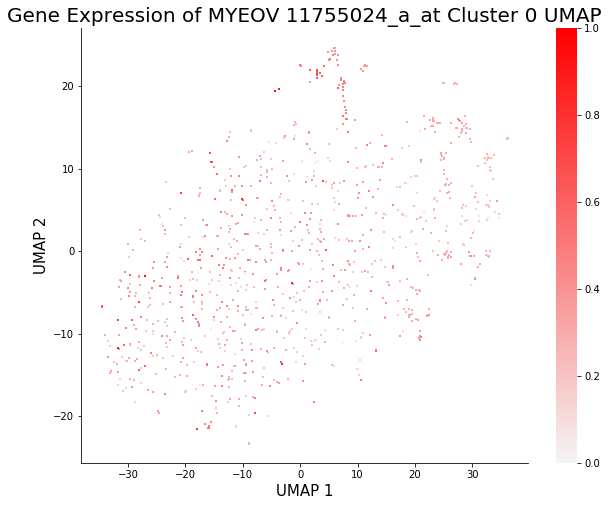

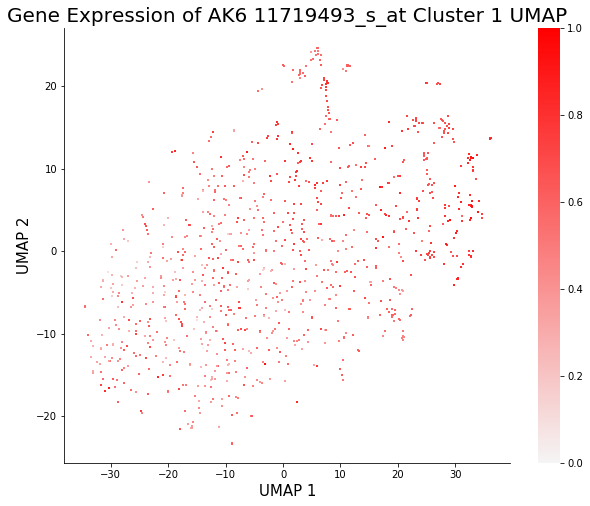

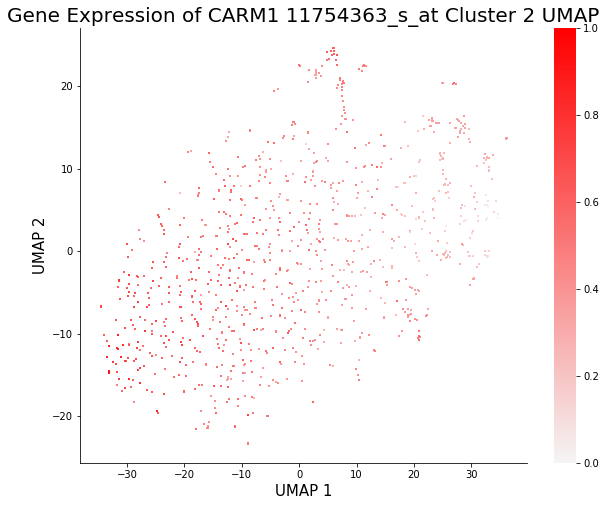

In [38]:
clust = hdb
for i in range(0, clust.where(clust>=0, 0).nunique()):
    pvalues = pd.Series(index=X.columns)
    statistics = pd.Series(index=X.columns)

    c = X.T[clust[clust == i].index]
    e = X.T[clust[clust != i].index]
    c_ = X.T[clust[clust == i].index].T
    e_ = X.T[clust[clust != i].index].T
    for gene in X.columns:
        statistics[gene], pvalues[gene] = stats.ranksums(c_[[gene]], e_[[gene]])
    markergene = statistics.sort_values(ascending=False).index[0]
    scatterplot(X_embedded, X[markergene], ge=True, title='Gene Expression of '+' '.join(markergene)+' Cluster '+str(i)+' ')

In [39]:
pd.crosstab(y, hdb, margins=True)

col_0,-1,0,1,2,All
row_0,,,,,
AD,50,48,112,50,260
CN,42,0,17,197,256
EMCI,57,1,15,187,260
LMCI,49,3,17,187,256
All,198,52,161,621,1032


In [40]:
X_embedded = UMAP(n_neighbors=40, min_dist=0.1, spread=1, n_components=2, metric='euclidean', random_state=r, n_epochs=2000).fit_transform(dfpc[:,:20])

In [2]:
scatterplot(X_embedded, y, labels=labels, umap=True)
plt.savefig('umap', format='svg', dpi=1200)

NameError: name 'X_embedded' is not defined

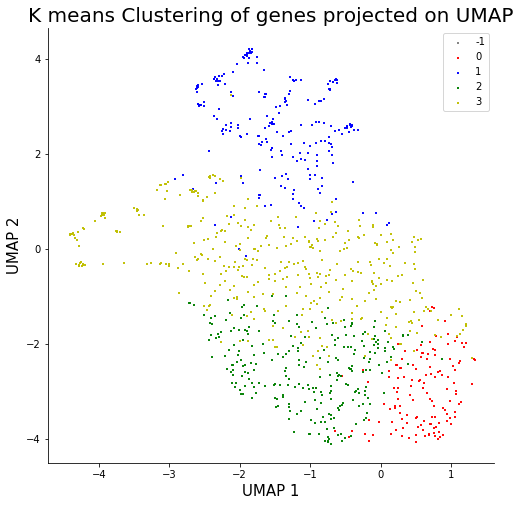

In [42]:
scatterplot(X_embedded, km, umap=True, title='K means Clustering of genes projected on ')

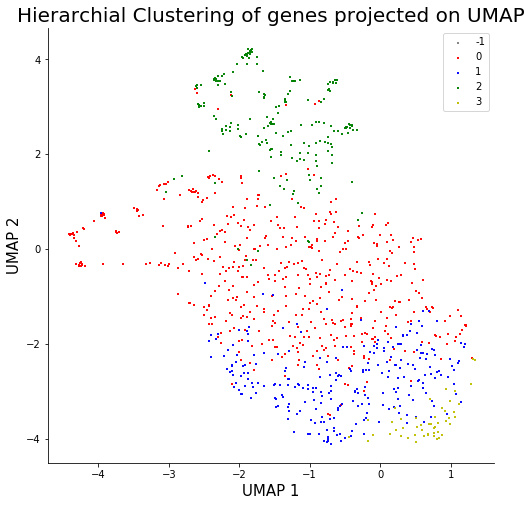

In [43]:
scatterplot(X_embedded, h, umap=True, title='Hierarchial Clustering of ')

In [44]:
#HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5)

y_hdb = hdb.fit_predict(X_embedded)
hdb = pd.Series(y_hdb)

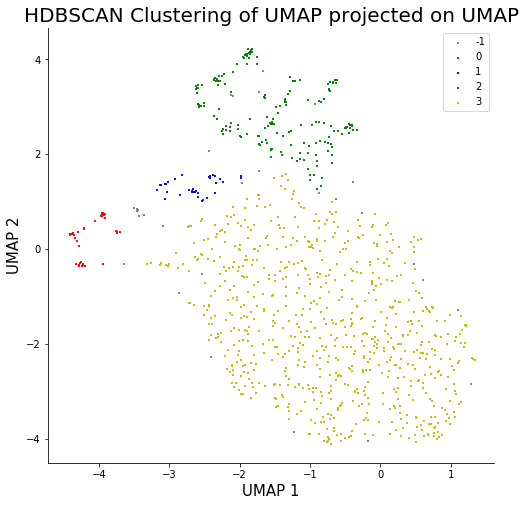

In [45]:
scatterplot(X_embedded, hdb, umap=True, title='HDBSCAN Clustering of ')
plt.savefig('hdbscanumap', format='svg', dpi=1200)

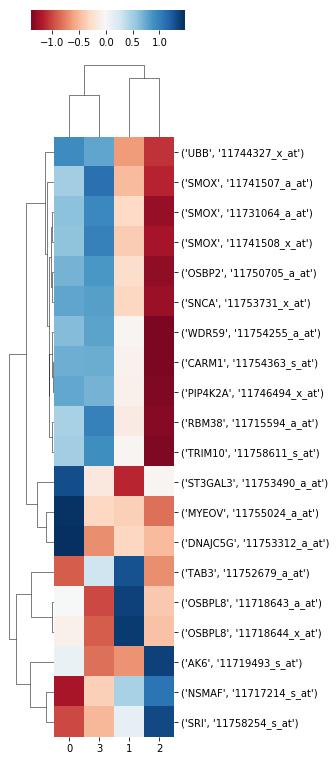

In [46]:
geheatmapclust(X, hdb, title='HDBSCAN Clustering of UMAP', side=2, top=0.5)
plt.savefig('gehdbscanumap', bbox_inches = "tight", format='svg', dpi=1200)

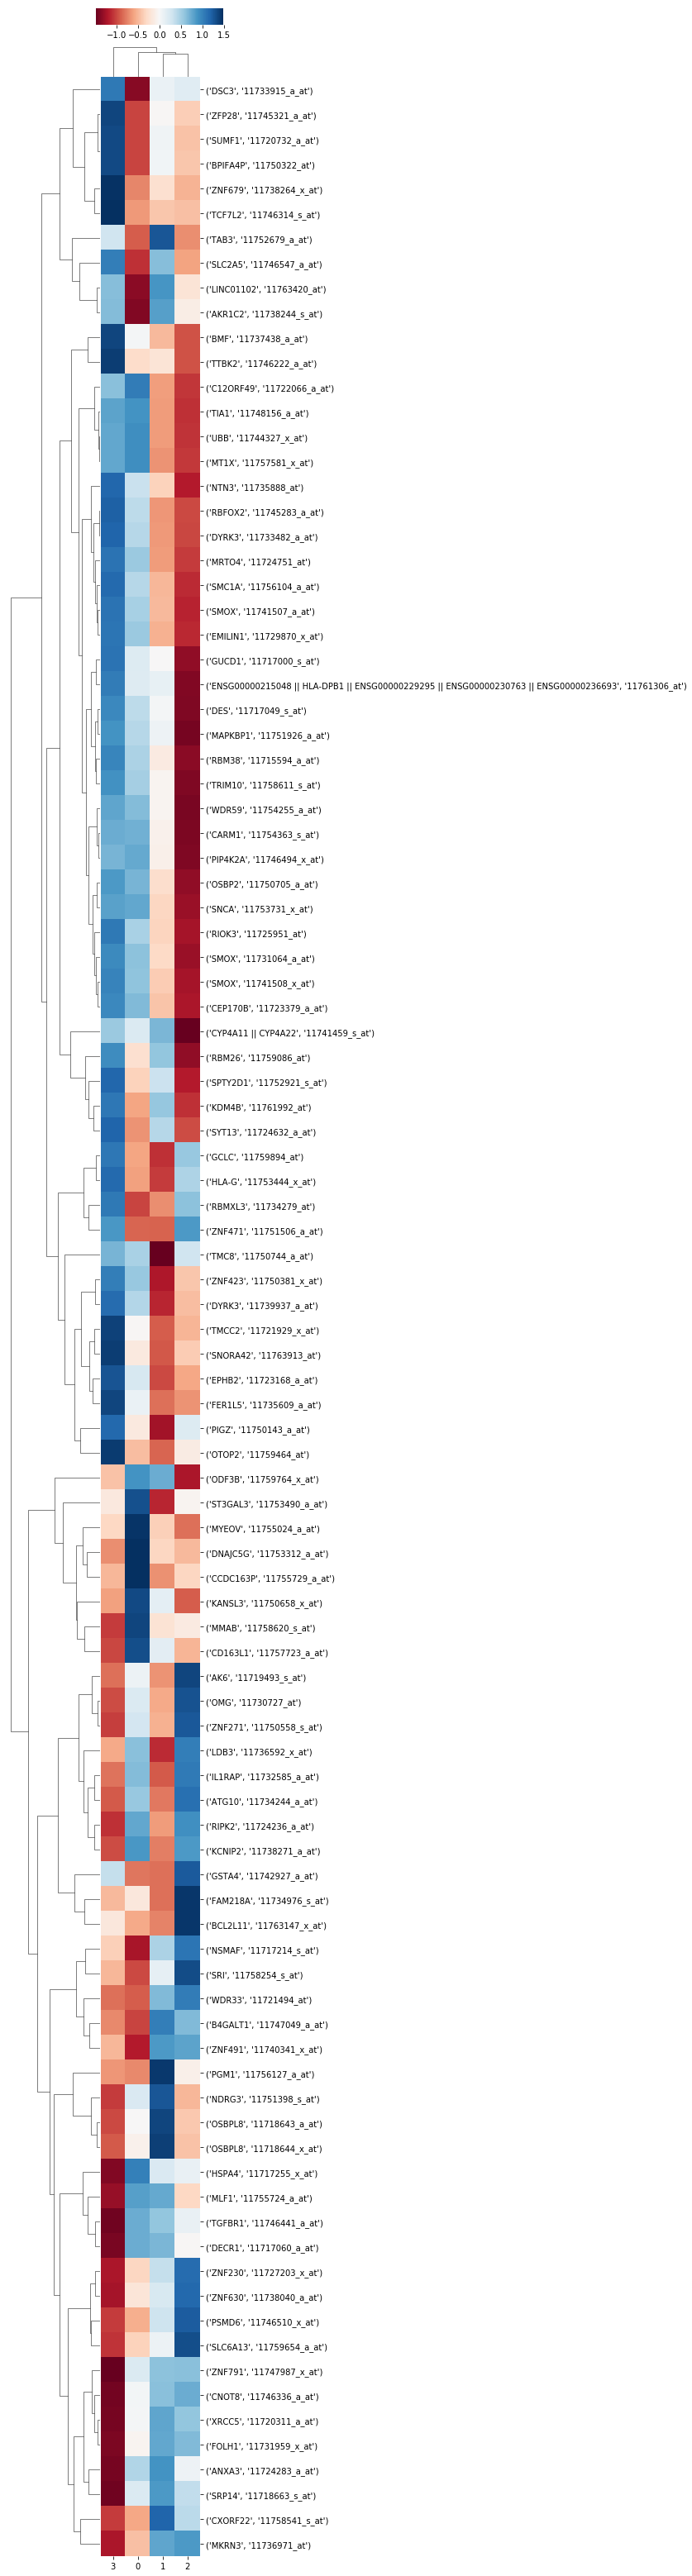

In [47]:
geheatmapclust(X, hdb, title='HDBSCAN Clustering of UMAP', num=100, bar=0.17)

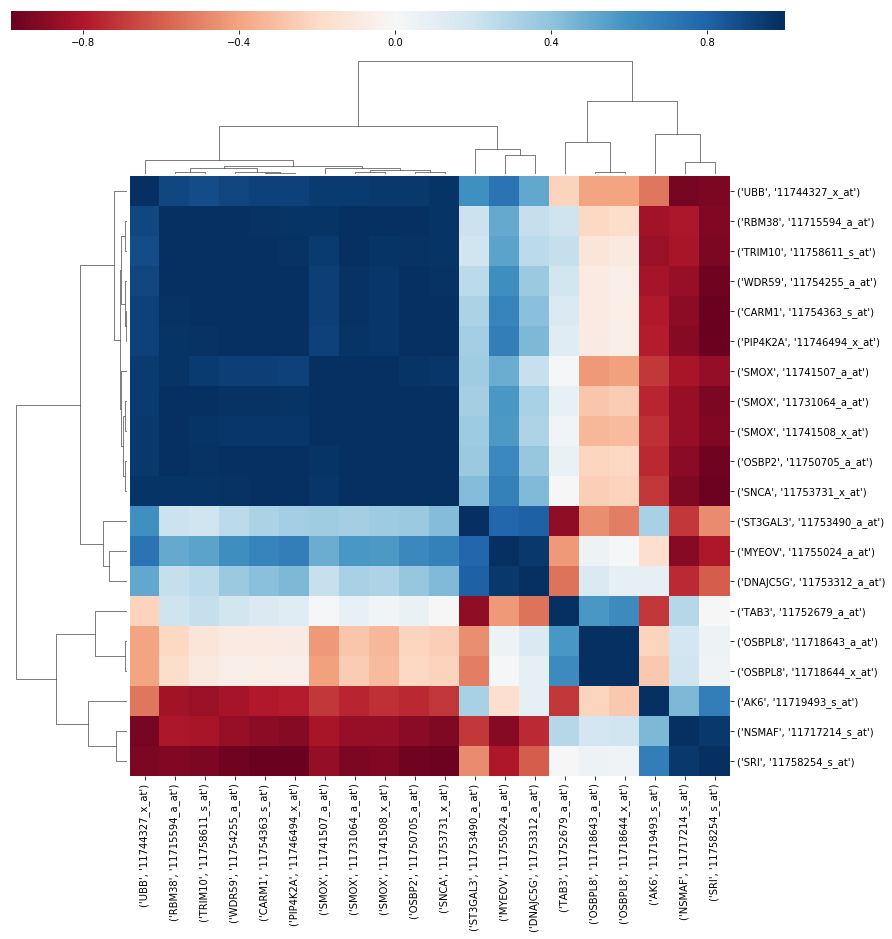

In [48]:
geheatmapclustgene(X, hdb, title='HDBSCAN Clustering of UMAP', top=1, side=1, up=0.25)

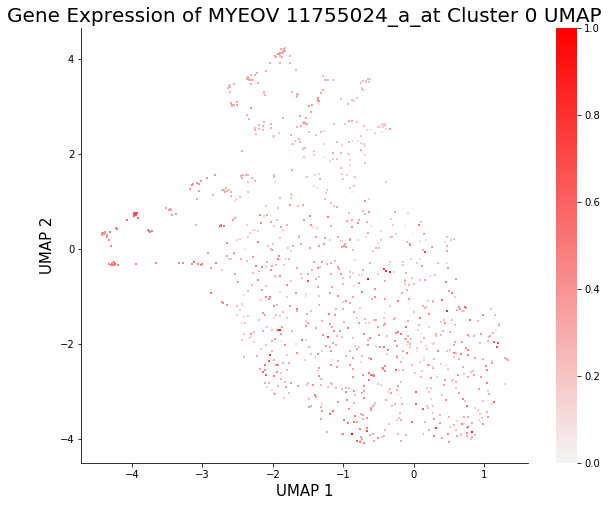

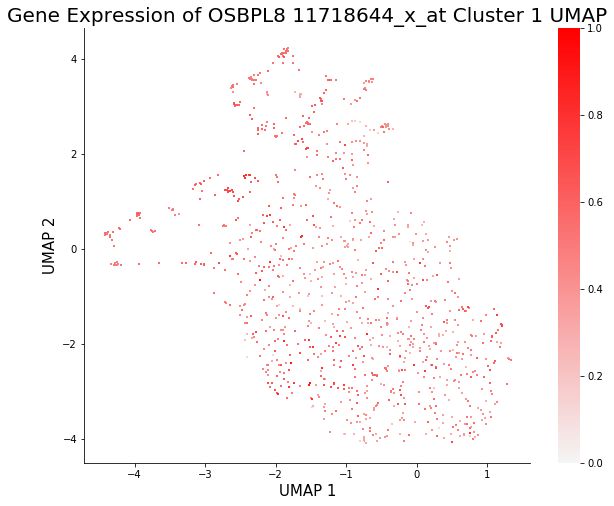

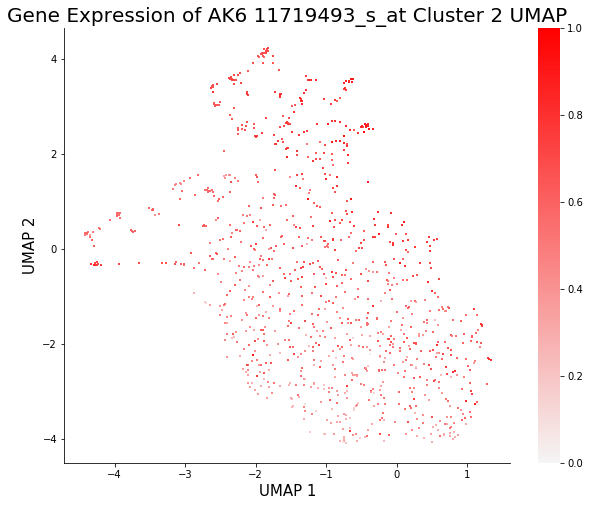

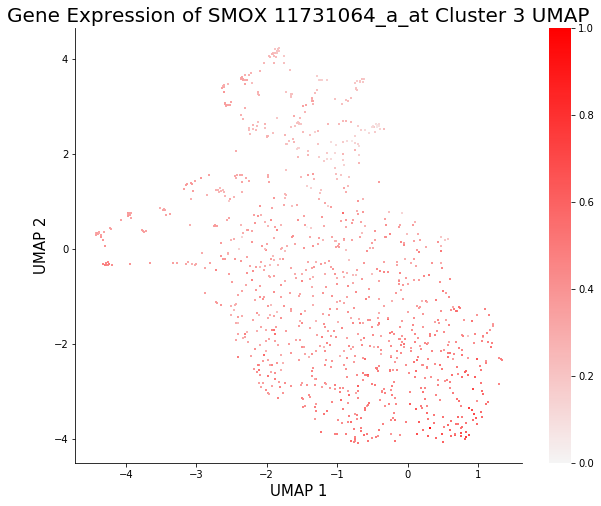

In [49]:
clust = hdb
for i in range(0, clust.where(clust>=0, 0).nunique()):
    pvalues = pd.Series(index=X.columns)
    statistics = pd.Series(index=X.columns)

    c = X.T[clust[clust == i].index]
    e = X.T[clust[clust != i].index]
    c_ = X.T[clust[clust == i].index].T
    e_ = X.T[clust[clust != i].index].T
    for gene in X.columns:
        statistics[gene], pvalues[gene] = stats.ranksums(c_[[gene]], e_[[gene]])
    markergene = statistics.sort_values(ascending=False).index[0]
    scatterplot(X_embedded, X[markergene], ge=True, title='Gene Expression of '+' '.join(markergene)+' Cluster '+str(i)+' ')

In [50]:
comb = hdb.replace(0, 0).replace(1, 0).replace(2, 0).replace(3, 1)

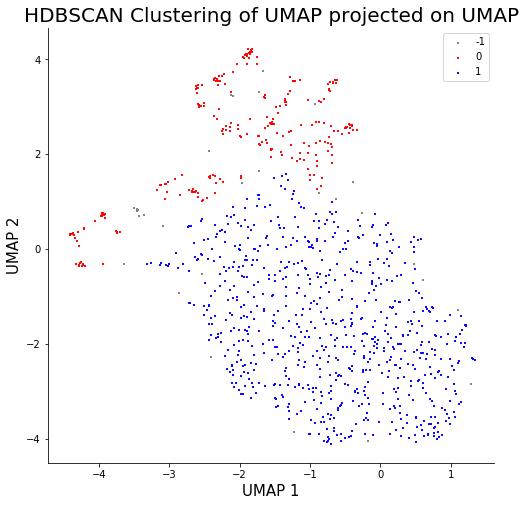

In [51]:
scatterplot(X_embedded, comb, umap=True, title='HDBSCAN Clustering of UMAP projected on ')

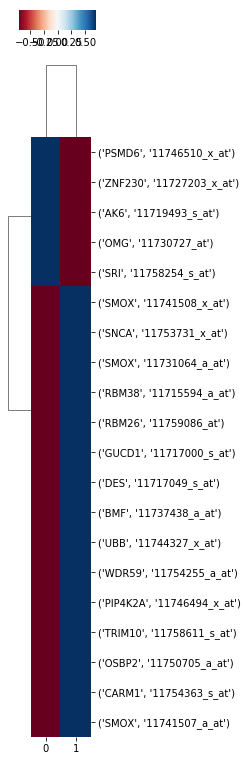

In [52]:
geheatmapclust(X, comb, title='HDBSCAN Clustering of UMAP', side=2, top=0.5)

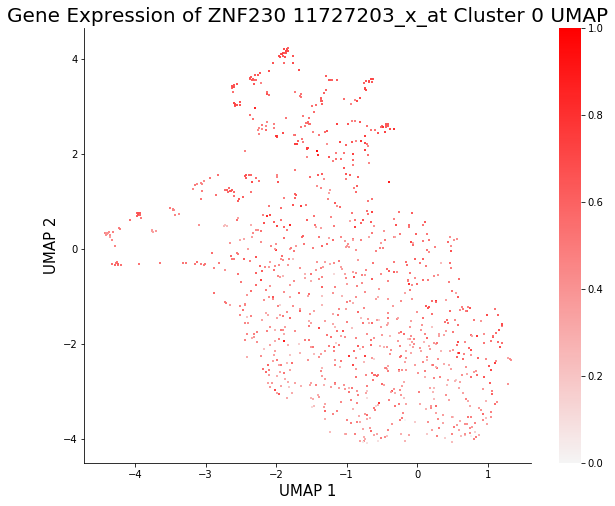

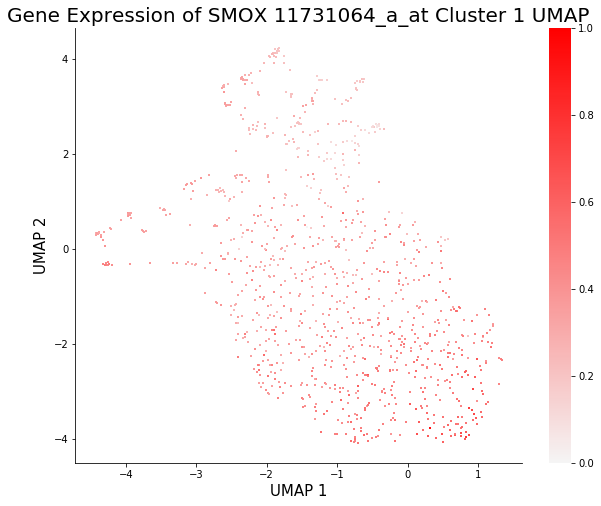

In [53]:
clust = comb
for i in range(0, clust.where(clust>=0, 0).nunique()):
    pvalues = pd.Series(index=X.columns)
    statistics = pd.Series(index=X.columns)

    c = X.T[clust[clust == i].index]
    e = X.T[clust[clust != i].index]
    c_ = X.T[clust[clust == i].index].T
    e_ = X.T[clust[clust != i].index].T
    for gene in X.columns:
        statistics[gene], pvalues[gene] = stats.ranksums(c_[[gene]], e_[[gene]])
    markergene = statistics.sort_values(ascending=False).index[0]
    scatterplot(X_embedded, X[markergene], ge=True, title='Gene Expression of '+' '.join(markergene)+' Cluster '+str(i)+' ')

In [54]:
pd.crosstab(y, hdb, margins=True)

col_0,-1,0,1,2,3,All
row_0,,,,,,
AD,14,38,31,129,48,260
CN,4,0,1,17,234,256
EMCI,4,0,0,16,240,260
LMCI,8,1,2,19,226,256
All,30,39,34,181,748,1032
